In [1]:
'''
Unsupervised k-means clustering on plain text file versions of EEBO-TCP texts. 
The plain text files are generated by running stageOne.py 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file also made using stageOne.py 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The pca function is adapted from Ask Python: 
    https://www.askpython.com/python/examples/plot-k-means-clusters-python 
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# import our own utility functions 
from functions import remove_stopwords,getTexts,keywords


def vectorize(strings,ids):
    # comment below is from EarlyPrint 
    # sublinear term frequency scaling takes the log of
    # term frequencies and can help to de-emphasize function words like pronouns and articles. 
    tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)

    # Commented out portion below is for removing stopwords 
    processed = remove_stopwords(strings)
    newStrings = []
    for doc in processed:
        str = ' '.join(doc)
        newStrings.append(str)
    results = tfidf.fit_transform(newStrings)
    
    # results = tfidf.fit_transform(strings) #comment this out if you choose to remove stopwords 
    return pd.DataFrame(results.toarray(), index=ids, columns=tfidf.get_feature_names_out()) # Convert information back to a DataFrame

def pca(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python 
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df)
    label = kmeans.fit_predict(pca_results)
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i)
    plt.legend()
    plt.show()

def cluster(df,ids,num):
    # Create a KMeans instance that will look for a specified number of clusters
    # Random_state parameter helps for reproducibility. 42 is a common choice 
    kmeans = KMeans(n_clusters=num, random_state=42) 
    kmeans.fit(df) 
    pca(kmeans,df)

    kmeans_groups = defaultdict(list)
    for k,v in zip(kmeans.labels_,ids):
        kmeans_groups[k].append(v)
        
    for k,v in kmeans_groups.items():
        print(k, ': ',v)

    return kmeans_groups

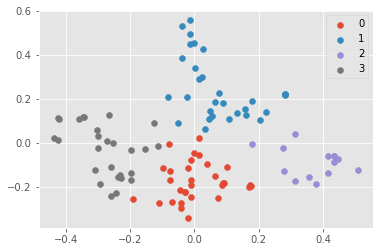

0 :  ['A11464', 'A11467', 'A34663', 'A80611', 'A80608', 'A80630', 'A80637', 'A34689', 'A34679', 'A34666', 'A13288', 'A13287', 'A13290', 'A19588', 'A19589', 'A19583', 'A19590', 'A17499', 'A69161', 'A19581', 'A02058', 'A15050', 'A01006', 'A01009', 'B13579', 'A01004', 'A01012', 'A01007', 'A06632', 'A01005', 'A01011']
2 :  ['A11472', 'A11474', 'A27888', 'A62166', 'A16552', 'A16457', 'A16527_01', 'A16527_02', 'A16527_03', 'A16527_04', 'A16469', 'A73472', 'A16564', 'A02495']
1 :  ['A27982', 'A73532', 'A16495', 'B00963', 'A16507', 'A14514', 'A14518', 'A14512', 'A14516', 'A14511', 'A14517', 'A14519', 'A14520', 'A14521', 'A10439', 'A10417', 'A10440', 'A10438', 'A10436', 'A68635', 'A68633', 'A34660', 'A34659', 'A02626', 'A04813', 'A34936', 'A02059', 'A19312', 'A67893', 'A19313']
3 :  ['A80614', 'A69149', 'A34693', 'A80640', 'A80633', 'A34599', 'A80625', 'A80622', 'B20736', 'A34673', 'A34678', 'B20727', 'A71036', 'A84399', 'B20729', 'A80626', 'A80639', 'A34672', 'A80635', 'A34675', 'A80636', 'A34

In [2]:
folder = '/srv/data/VirginiaEPTextClean'
csvFile = '/srv/data/metadata/tuning/virginia.csv'
info = getTexts(folder)
df = vectorize(info[0],info[1])
groups = cluster(df,info[1],4)

In [3]:
words = keywords(csvFile)
for k,v in groups.items():
    print(f'Group {k}')
    keyterms = []
    for name in v: 
        if '_' not in name:
            keyterms.extend(words[name][0])
    print(Counter(keyterms))

Group 0
Counter({'Controversial literature': 9, 'Bible': 9, 'Catholic Church': 8, 'NT': 6, 'Sermons': 5, 'Sermons English': 5, 'Commentaries': 4, 'OT': 3, 'Religion': 2, 'Europe': 2, 'History': 2, 'Colonial period': 2, 'Virginia': 2, 'Protestantism': 2, 'Sir': 2, 'Religious aspects': 2, 'Religion of Protestants a safe way to salvation': 2, 'Chillingworth William': 2, 'Song of Solomon': 1, 'John 1st V': 1, 'Sermons American': 1, 'Liberty of conscience': 1, 'Bloody tenent of persecution foruse of conscience': 1, 'Williams Roger ?': 1, 'Religious tolerance': 1, 'Prophecies': 1, 'Revelation XVI': 1, 'Acts VII 8': 1, 'Grace': 1, 'Epistle of John 1st': 1, 'Revelation XIII': 1, 'Criticism interpretation etc': 1, 'Ecclesiastes': 1, 'Papacy': 1, 'Revelation': 1, 'Colonies': 1, 'Genesis XII 13': 1, 'Doctrines': 1, 'United States': 1, 'Colonization': 1, 'Devotional literature': 1, 'Jesuits': 1, 'Mary': 1, 'Scribanius Carolus': 1, 'Blessed Virgin Saint': 1, 'Legends': 1, 'Plague': 1, 'London': 1, 